In [8]:
from connections import AWS

In [10]:
aws = AWS()
aws.connect()

[AWS]: Port 5433 is in use by process python3.11 (PID 20516). Killing it.
[AWS]: Connected to RDS endpoint.


In [11]:
# load all predictions
statcast_preds = aws.load_s3_object('epidemiology/ml/datasets/preds/model_application.csv')

$\textbf{Workload Totals}$

In [19]:
import pandas as pd

In [95]:
def get_workload_totals(
        data: pd.DataFrame,
        max_days_rest: int = 6
) -> pd.DataFrame:
    """
    Aggregate total EVT workload by days of rest. Only includes up to `max_days_rest` days of rest (defaults to 6).
    
    Args:
        data (pd.DataFrame): DataFrame containing predictions with 'pitcher', 'game_date', 
                             'pitcher_days_since_prev_game', and 'pred_peak_evt_normalized'.
        max_days_rest (int): Maximum number of days of rest to consider for aggregation.
                             
    Returns:
        pd.DataFrame: DataFrame with aggregated total EVT workload by days of rest.
    """
    totals = data.groupby(['pitcher', 'game_date', 'pitcher_days_since_prev_game']).agg(
        pitches_thrown=('pitch_id', 'count'),
        total_evt_workload=('pred_peak_evt_normalized', 'sum')
    ).reset_index()
    
    return totals[
        (totals['pitcher_days_since_prev_game'] > 0) & 
        (totals['pitcher_days_since_prev_game'] <= max_days_rest)
    ].reset_index(drop=True)


In [96]:
# separate injured and non-injured players
statcast_injured = statcast_preds[statcast_preds['injured_cohort_pitcher'] == 1].reset_index(drop=True)
statcast_noninjured = statcast_preds[statcast_preds['injured_cohort_pitcher'] == 0].reset_index(drop=True)

In [97]:
# aggregate total EVT workload by days of rest
noninj_totals = get_workload_totals(statcast_noninjured)
inj_totals = get_workload_totals(statcast_injured)

# compute averages by day 
inj_avgs_by_day = inj_totals.groupby('pitcher_days_since_prev_game').agg(
    total_evt_workload=('total_evt_workload', 'mean'),
    std_evt_workload=('total_evt_workload', 'std'),
    pitches_thrown=('pitches_thrown', 'mean')
).reset_index().sort_values(by='pitcher_days_since_prev_game')
noninj_avgs_by_day = noninj_totals.groupby('pitcher_days_since_prev_game').agg(
    total_evt_workload=('total_evt_workload', 'mean'),
    std_evt_workload=('total_evt_workload', 'std'),
    pitches_thrown=('pitches_thrown', 'mean')
).reset_index().sort_values(by='pitcher_days_since_prev_game')

$\textbf{Preliminary Clinical Recommendations}$

In [98]:
# TBD

$\textbf{Plots}$

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

$\textit{Non-injured Pitchers}$

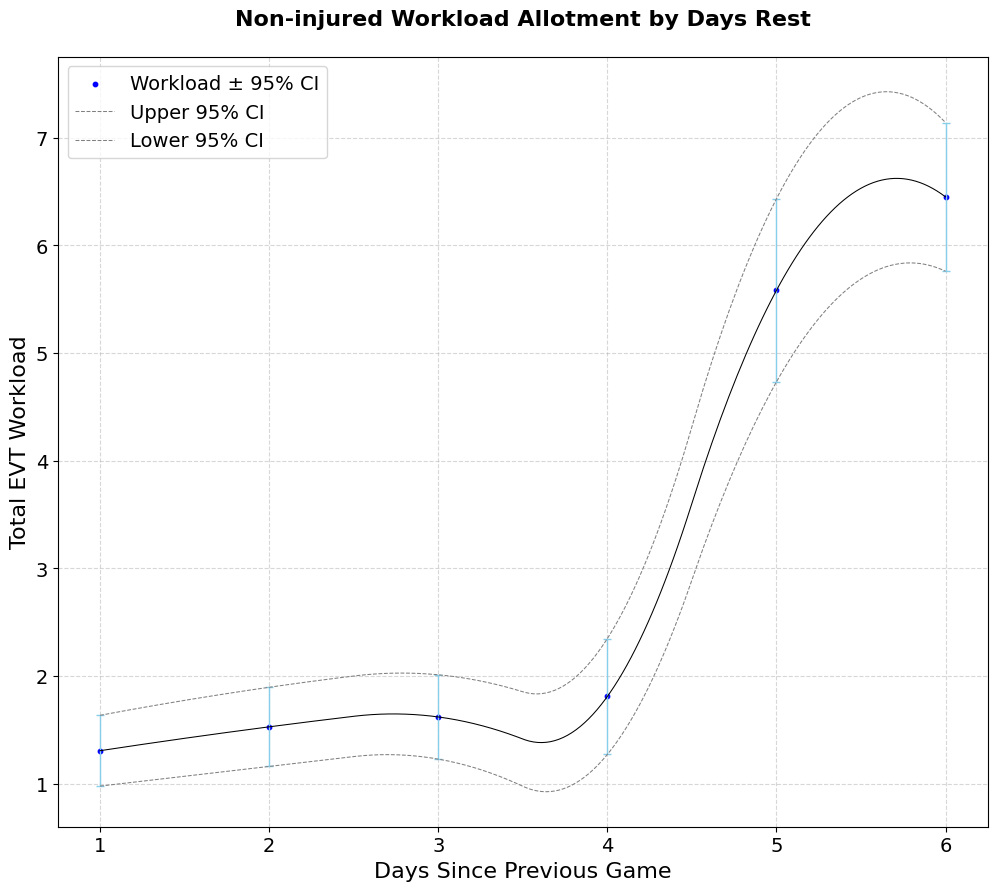

In [124]:
fig, ax = plt.subplots(figsize=(12, 10))

# plot the points
ax.scatter(
    inj_avgs_by_day['pitcher_days_since_prev_game'],
    inj_avgs_by_day['total_evt_workload'],
    color='blue',
    marker='o',
    s=10,
    label='Workload ± 95% CI'
)

# add error bars
ax.errorbar(
    inj_avgs_by_day['pitcher_days_since_prev_game'],
    inj_avgs_by_day['total_evt_workload'],
    yerr=1.96 * inj_avgs_by_day['std_evt_workload'] / np.sqrt(inj_avgs_by_day['pitches_thrown']),
    fmt='none',
    ecolor='skyblue',
    elinewidth=1,
    capsize=3
)

# fit a spline to the mean ± error bars (upper and lower bounds)
yerr = 1.96 * inj_avgs_by_day['std_evt_workload'] / np.sqrt(inj_avgs_by_day['pitches_thrown'])
y_upper = inj_avgs_by_day['total_evt_workload'] + yerr
y_lower = inj_avgs_by_day['total_evt_workload'] - yerr

# plot the upper and lower bounds
x = inj_avgs_by_day['pitcher_days_since_prev_game']
x_smooth = np.linspace(x.min(), x.max(), 200)

# fit splines for upper and lower bounds
spline_upper = UnivariateSpline(x, y_upper, k=2, s=0)
spline_lower = UnivariateSpline(x, y_lower, k=2, s=0)
ax.plot(x_smooth, spline_upper(x_smooth), color='gray', linestyle='--', linewidth=0.75, label='Upper 95% CI')
ax.plot(x_smooth, spline_lower(x_smooth), color='gray', linestyle='--', linewidth=0.75, label='Lower 95% CI')

# spline interpolation
x = inj_avgs_by_day['pitcher_days_since_prev_game']
y = inj_avgs_by_day['total_evt_workload']
spline = UnivariateSpline(x, y, k=2, s=0)
x_smooth = np.linspace(x.min(), x.max(), 200)
y_smooth = spline(x_smooth)
ax.plot(x_smooth, y_smooth, color='black', label='', linewidth=0.75)

# make ticks, labels larger
ax.set_xlabel('Days Since Previous Game', fontsize=16)
ax.set_ylabel('Total EVT Workload', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# add title
ax.set_title('Non-injured Workload Allotment by Days Rest\n', fontsize=16, fontweight='bold')

# show legend, grids
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=14)

plt.show()

$\textit{Add Injured Pitchers}$

In [101]:
from scipy.stats import ttest_ind

In [104]:
# perform t-test for each day of rest
ttest_results = {}
for day in range(1, 7):
    inj_workload = inj_totals[inj_totals['pitcher_days_since_prev_game'] == day]['total_evt_workload']
    noninj_workload = noninj_totals[noninj_totals['pitcher_days_since_prev_game'] == day]['total_evt_workload']
    
    if not inj_workload.empty and not noninj_workload.empty:
        t_stat, p_value = ttest_ind(inj_workload, noninj_workload, alternative='greater')
        ttest_results[day] = (t_stat, p_value)
        print(f"Day {day}: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")
    
    else:
        print(f"Day {day}: Not enough data for t-test")

Day 1: t-statistic = -0.176, p-value = 0.570
Day 2: t-statistic = 3.093, p-value = 0.001
Day 3: t-statistic = 0.323, p-value = 0.373
Day 4: t-statistic = 1.337, p-value = 0.091
Day 5: t-statistic = 1.660, p-value = 0.049
Day 6: t-statistic = 3.207, p-value = 0.001


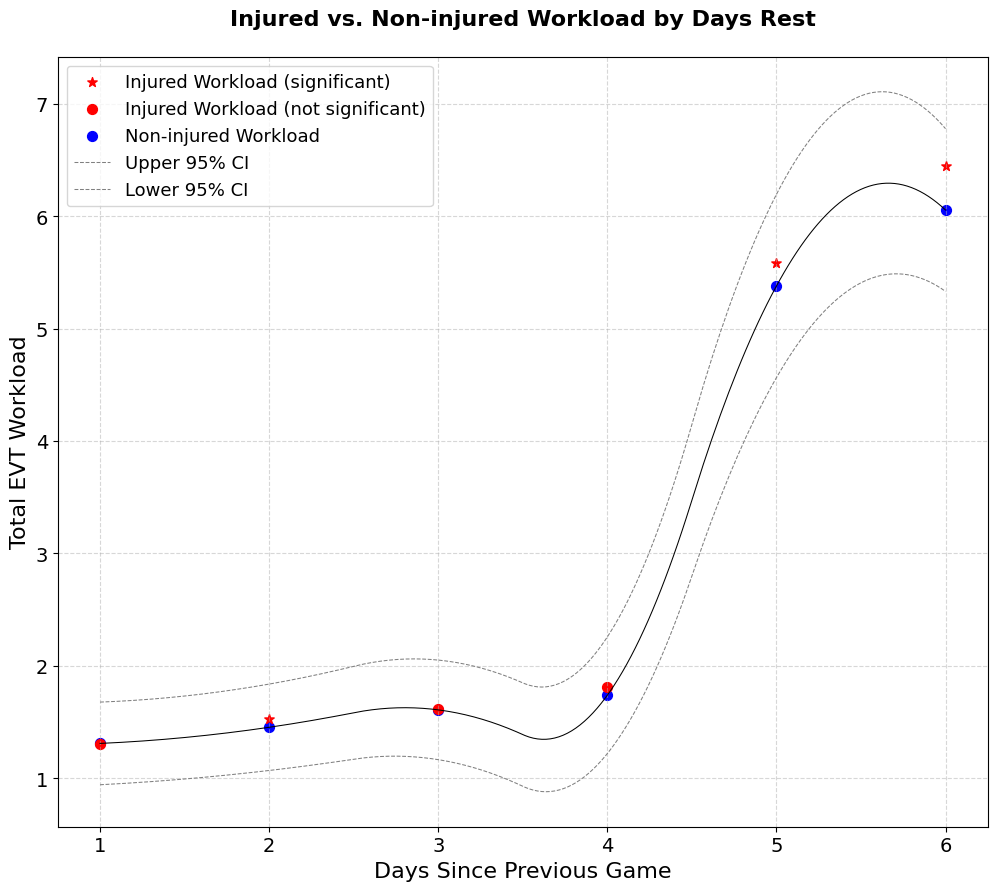

In [126]:
fig, ax = plt.subplots(figsize=(12, 10))

# plot the points
ax.scatter(
    noninj_avgs_by_day['pitcher_days_since_prev_game'],
    noninj_avgs_by_day['total_evt_workload'],
    color='blue',
    marker='o',
    s=50,
    label='Non-injured Workload'
)

# NOTE: no error bars

# fit a spline to the mean ± error bars (upper and lower bounds)
yerr = 1.96 * noninj_avgs_by_day['std_evt_workload'] / np.sqrt(noninj_avgs_by_day['pitches_thrown'])
y_upper = noninj_avgs_by_day['total_evt_workload'] + yerr
y_lower = noninj_avgs_by_day['total_evt_workload'] - yerr

# plot the upper and lower bounds
x = noninj_avgs_by_day['pitcher_days_since_prev_game']
x_smooth = np.linspace(x.min(), x.max(), 200)

# fit splines for upper and lower bounds
spline_upper = UnivariateSpline(x, y_upper, k=2, s=0)
spline_lower = UnivariateSpline(x, y_lower, k=2, s=0)
ax.plot(x_smooth, spline_upper(x_smooth), color='gray', linestyle='--', linewidth=0.75, label='Upper 95% CI')
ax.plot(x_smooth, spline_lower(x_smooth), color='gray', linestyle='--', linewidth=0.75, label='Lower 95% CI')

# spline interpolation
x = noninj_avgs_by_day['pitcher_days_since_prev_game']
y = noninj_avgs_by_day['total_evt_workload']
spline = UnivariateSpline(x, y, k=2, s=0)
x_smooth = np.linspace(x.min(), x.max(), 200)
y_smooth = spline(x_smooth)
ax.plot(x_smooth, y_smooth, color='black', label='', linewidth=0.75)


# add asterisks for significant t-test results
for idx, row in inj_avgs_by_day.iterrows():
    day = int(row['pitcher_days_since_prev_game'])
    x_val = row['pitcher_days_since_prev_game']
    y_val = row['total_evt_workload']
    if day in ttest_results:
        if ttest_results[day][1] < 0.05:
            ax.scatter(
                x_val,
                y_val,
                color='red',
                marker='*',
                s=50,
                edgecolor='red',
                label='Injured Workload (significant)'
            )
        else:
            ax.scatter(
                x_val,
                y_val,
                color='red',
                marker='o',
                s=50,
                edgecolor='red',
                label='Injured Workload (not significant)'
            )

# make ticks, labels larger
ax.set_xlabel('Days Since Previous Game', fontsize=16)
ax.set_ylabel('Total EVT Workload', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# add title
ax.set_title('Injured vs. Non-injured Workload by Days Rest\n', fontsize=16, fontweight='bold')

# show legend, grids
ax.grid(True, linestyle='--', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
order = [labels.index('Injured Workload (significant)'), labels.index('Injured Workload (not significant)'), labels.index('Non-injured Workload'), labels.index('Upper 95% CI'), labels.index('Lower 95% CI')]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=13)

plt.show()